In [1]:
import numpy as np
import os
import pytorch_lightning as pl
import torch

from config import *
from data_module import VideoDataModule
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from tqdm import tqdm
import torchmetrics

from sklearn.metrics import(
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
)

from custom_efficientnet import *

In [2]:
# Determine Device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using: ", device)
torch.cuda.empty_cache()

Using:  cuda


In [3]:
batch_size = 40
experiment_name = "efficientnet_with_class_weights"
learning_rate = .0001
max_epochs = 20

In [12]:
def calculate_class_weights(loader):
    unique_classes = list(NUM_TO_LABEL.keys())
    total_labels = np.array([])
    
    for batch in tqdm(loader):
        data = batch[0]["label"]
        batch_labels = torch.argmax(data, dim=1).detach().cpu().numpy()
        total_labels = np.concatenate([total_labels, batch_labels])
    
    weights = class_weight.compute_class_weight(
        "balanced", 
        classes=unique_classes, 
        y=total_labels
    )
    class_weights = torch.FloatTensor(weights).to(device)
    return class_weights


def evaluate_model(model, data, batch_size, device):
    # Set model to eval and put on device
    model.eval()
    model.to(device)

    predicted_label = []
    actual_label = []

    classes = [NUM_TO_LABEL[i] for i in range(NUM_CLASSES)]

    for batch in tqdm(data):
        # Get Data
        data = batch[0]["data"]
        # Remove sequence length dim
        data = torch.squeeze(data, 1).reshape(batch_size, 3, 189, 224)
        label = batch[0]["label"]

        # Make Predictions
        outputs = model(data)

        # Decode prediction from one hot encoding ([0, 1, 0] --> 1)
        predicted_class = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        actual_class = torch.argmax(label, dim=1).detach().cpu().numpy()

        # Save Results
        predicted_label.append(predicted_class)
        actual_label.append(actual_class)

    # Flatten lists (num_batches, batch_size) -> (batch_size * num_batches)
    actual_label = np.array(actual_label).flatten()
    predicted_label = np.array(predicted_label).flatten()

    # Create confusion matrix
    cm_train = confusion_matrix(actual_label, predicted_label)
    confusion_matrix_object = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=classes)
    confusion_matrix_object.plot()

    # Calculate metrics
    accuracy = accuracy_score(actual_label, predicted_label)

    # Display metrics
    print(f"Accuracy: {accuracy}")
    
    return confusion_matrix_object

In [6]:
video_data_module = VideoDataModule(
        batch_size, 
        TRAIN_FILE_LIST, 
        TEST_FILE_LIST, 
        EVAL_FILE_LIST, 
        TRAIN_SIZE, 
        TEST_SIZE, 
        EVAL_SIZE
    )

In [10]:
training_loader = video_data_module.train_dataloader()

training_class_weights = calculate_class_weights(training_loader)

/usr/local/lib/python3.11/dist-packages/nvidia/dali/plugin/base_iterator.py:207: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
  0%|          | 31/8754 [00:03<14:49,  9.81it/s]


KeyboardInterrupt: 

In [6]:
# Create logger
logger = TensorBoardLogger(
    "tensor_board_logs", 
    name=experiment_name,
)

# Create checkpoint callback (Saves model state)
checkpoint_callback = ModelCheckpoint(
    dirpath=f'./checkpoints/{experiment_name}', 
    save_on_train_epoch_end=True,
    monitor='testing_accuracy',
    mode='max',
    filename="{experiment_name}_epoch_{epoch}_val_accuracy_{testing_accuracy:.2f}_step_{step}",
    save_top_k=5,
    every_n_epochs=1,
)

# Runs Val every epoch
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=1, 
    max_epochs=max_epochs,
    default_root_dir=os.getcwd(),
    callbacks=[checkpoint_callback],
    logger=logger,
    check_val_every_n_epoch=3,
    # fast_dev_run=True
)

my_efficientnet = MyEfficientNet(
    NUM_CLASSES,
    batch_size,
    learning_rate,
    class_weights = training_class_weights
).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [7]:
# Train model
trainer.fit(my_efficientnet, video_data_module)

# Save final checkpoint
trainer.save_checkpoint(f"./final_checkpoints/{experiment_name}/final_checkpoint")

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /kaanan_workspace/checkpoints/EfficientNet_trial_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | CrossEntropyLoss | 0     
1 | efficientnet | EfficientNet     | 20.2 M
--------------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.725    Total estimated model params size (MB)
/usr/local/lib/python3.11/dist-packages/nvidia/dali/plugin/base_iterator.py:207: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


/usr/local/lib/python3.11/dist-packages/nvidia/dali/plugin/base_iterator.py:207: Warning: Please set `reader_name` and don't set last_batch_padded and size manually whenever possible. This may lead, in some situations, to missing some samples or returning duplicated ones. Check the Sharding section of the documentation for more details.
  _iterator_deprecation_warning()
100%|██████████| 3577/3577 [02:25<00:00, 24.65it/s]


Accuracy: 0.6782219737209952


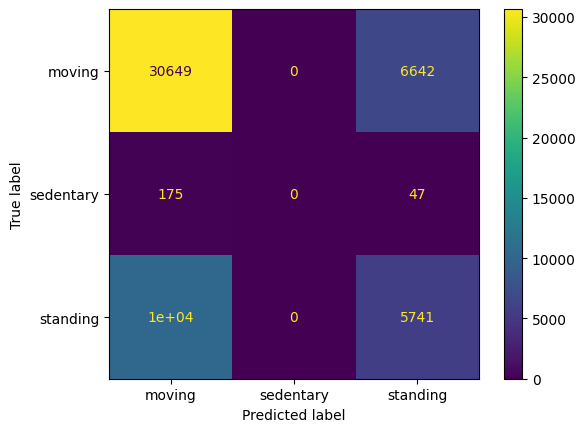

In [16]:
# Extract validation dataloader from data module
val_data = video_data_module.val_dataloader()

# Get confusion matrix and metrics
confusion_matrix_ = evaluate_model(my_efficientnet, val_data, device)
confusion_matrix_.figure_.savefig(f'./confusion_matrices/{experiment_name}_validation_confusion_matrix.png')

100%|██████████| 8754/8754 [18:46<00:00,  7.77it/s]


Accuracy: 0.9922235549463102


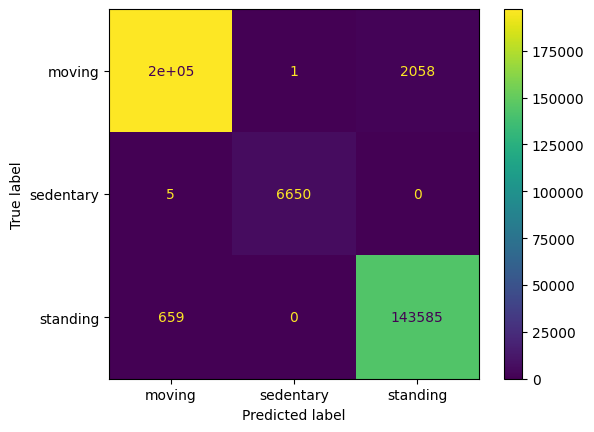

In [19]:
# Extract validation dataloader from data module
train_data = video_data_module.train_dataloader()

# Get confusion matrix and metrics
confusion_matrix_ = evaluate_model(my_efficientnet, train_data, batch_size, device)
confusion_matrix_.figure_.savefig(f'./confusion_matrices/{experiment_name}_training_confusion_matrix.png')

In [24]:
model = MyEfficientNet.load_from_checkpoint(
                    "final_checkpoints/EfficientNet_trial_1/final_checkpoint",  
                    num_classes=3,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    fine_tune=False,
                ).to(device)
model = torch.nn.Sequential(*(list(list(model.children())[1].children())[:-1]))

In [25]:
train_data = video_data_module.train_dataloader()
for batch in tqdm(train_data):
        # Get Data
        data = batch[0]["data"]
        # Remove sequence length dim
        data = torch.squeeze(data, 1).reshape(batch_size, 3, 189, 224)
        print(model(data))
        break

  0%|          | 0/8754 [00:00<?, ?it/s]

tensor([[[[ 0.1304]],

         [[-0.0372]],

         [[ 0.2176]],

         ...,

         [[-0.0690]],

         [[ 0.0859]],

         [[-0.1379]]],


        [[[ 0.2648]],

         [[-0.1201]],

         [[ 0.1842]],

         ...,

         [[ 0.1799]],

         [[ 0.3865]],

         [[-0.0230]]],


        [[[-0.0548]],

         [[ 0.0212]],

         [[-0.0866]],

         ...,

         [[-0.0159]],

         [[-0.0608]],

         [[ 0.4337]]],


        ...,


        [[[-0.1340]],

         [[-0.1642]],

         [[-0.1339]],

         ...,

         [[-0.0977]],

         [[ 0.2358]],

         [[-0.2064]]],


        [[[ 0.9404]],

         [[ 0.9802]],

         [[ 0.2838]],

         ...,

         [[ 0.0442]],

         [[ 0.3163]],

         [[ 0.2602]]],


        [[[ 0.0081]],

         [[-0.1020]],

         [[-0.1258]],

         ...,

         [[ 0.0378]],

         [[-0.1299]],

         [[ 0.0219]]]], device='cuda:0')
